# SET ENVIRONMENT

In [1]:
# allows to import own functions
import sys
import os
import re
root_project = re.findall(r'(^\S*TFM)', os.getcwd())[0]
sys.path.append(root_project)

In [2]:
import pandas as pd
from src.features.add_features import add_features
from sklearn.model_selection import  train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.regressor import residuals_plot, prediction_error, PredictionError
from yellowbrick.model_selection import validation_curve, learning_curve, feature_importances
import pickle
from src.utils.help_func import rename_indicators

sns.set()

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
seed = 42
df_raw = pd.read_csv("../../data/processed/simulation_results_REV4.csv")
df_raw = df_raw.sample(15000, random_state=seed)
df_raw.head()

,i_country,R0,Tc,Tr,omega,ind_inf_1,ind_inf_2,ind_inf_sumgrad,ind_inf_p,ind_mort_1,ind_mort_2,ind_mort_3,ind_mort_sumgrad,n_closed,react_time,total_infected,total_deceased,total_recovered
46730,NIC,2.726164,2.880362,7.852337,0.333682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,16,13,1.0,0.0,0.0
48393,TTO,15.615708,1.581239,24.692166,0.508220,5.233333,10.139389,23.526981,0.000113,0.783439,4.970197,10.266054,10.5,15,14,359605.0,333040.0,26437.0
41416,SUR,13.349681,1.923908,25.683558,0.438960,2.000000,2.419256,6.085120,0.000104,0.850000,8.045612,8.642644,2.0,18,13,156036370.0,142061448.0,12594398.0
34506,VEN,12.878925,1.575816,20.294810,0.665217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,19,15,1.0,0.0,0.0
43725,TKM,6.054086,2.731820,16.538675,0.678012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7,1,1.0,0.0,0.0


In [4]:
df = add_features(df_raw)
df = rename_indicators(df)

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df = df.loc[df['total_deceased'] > 1 ]
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(10099, 39)
(9624, 39)


In [6]:
features = [
    'ind_1.1',
    'ind_1.2',
    'ind_1.3',
    'ind_1.4',
    'ind_2.1',
    'ind_2.2',
    'ind_2.3',
    'ind_2.4',
    'n_closed',
    'react_time',
    'betweenness_log',
    'degree_log',
    'closeness',
    'country_pop_log',
    'country_departures_log',
    'exposed_pop_log',
    'affected_population'
    ]

df = df[features]
df.head()

,ind_1.1,ind_1.2,ind_1.3,ind_1.4,ind_2.1,ind_2.2,ind_2.3,ind_2.4,n_closed,react_time,betweenness_log,degree_log,closeness,country_pop_log,country_departures_log,exposed_pop_log,affected_population
48393,3.158148,-9.088466,1.655048,2.316428,2.351375,-0.244061,1.603460,2.328843,15,14,-5.547479,-2.106841,0.441352,14.144712,6.616065,19.965769,0.000044
41416,1.805846,-9.169503,0.693147,0.883460,0.693147,-0.162519,2.085127,2.156709,18,13,-8.140420,-2.917771,0.385417,13.263847,6.700731,19.249124,0.018858
24656,10.979096,-6.045470,8.352413,9.572624,9.948628,-0.634691,-0.050146,1.791781,4,9,-9.577623,-2.144581,0.393617,17.799080,9.513994,21.921267,0.473662
22411,12.998546,1.544631,9.723803,8.968487,9.553717,-2.093050,-2.184036,-0.079092,2,7,-5.853222,-2.917771,0.388792,11.580369,7.012115,19.616169,0.440854
936,12.068965,-8.469177,9.184157,10.229026,10.572662,-0.906085,-0.595658,1.349568,7,19,-3.484589,-0.574364,0.560606,21.054532,12.924383,22.212935,0.131193


# DATA PREPARATION

In [7]:
X = df.drop('affected_population', axis=1)
y = df['affected_population']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  random_state=seed)

In [8]:
def ResultsRegressorCV(scores):
    print(f"R2: {scores['test_r2'].mean()}, {scores['test_r2'].std()}")
    print(f"MAE: {-scores['test_neg_mean_absolute_error'].mean()}, {scores['test_neg_mean_absolute_error'].std()}")
    print(f"RMSE: {-scores['test_neg_root_mean_squared_error'].mean()}, {scores['test_neg_root_mean_squared_error'].std()}")
    return None

def make_scores(d_score, model_name):
    try:
        df = pd.read_pickle('scores_models.pkl')
        df[model_name] = list(d_score.values())
        df.to_pickle('scores_models.pkl')
    except:
        s = pd.Series(d_score)
        s.name = model_name
        df = pd.DataFrame(s)
        df.to_pickle('scores_models.pkl')

# MODEL

In [9]:
estimator = DecisionTreeRegressor(random_state=seed)

pipe = Pipeline(
    [
        ("estimator", estimator),
    ]
)

In [10]:
score = cross_validate(pipe, X, y, n_jobs=-1, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
ResultsRegressorCV(score)

R2: 0.753927912734621, 0.028280214405490705
MAE: 0.054096123658748295, 0.002764984695457024
RMSE: 0.09974574708948943, 0.006802912168028006


In [11]:
make_scores(score, 'Decision Tree')

In [12]:
score

{'fit_time': array([0.08486724, 0.08411169, 0.08489013, 0.08530903, 0.08593345]),
 'score_time': array([0.0021143 , 0.00213003, 0.00215578, 0.00218177, 0.0022099 ]),
 'test_r2': array([0.79534835, 0.77904517, 0.73897199, 0.72112616, 0.73514789]),
 'test_neg_mean_absolute_error': array([-0.0499434 , -0.05238717, -0.05476699, -0.0581299 , -0.05525315]),
 'test_neg_root_mean_squared_error': array([-0.09018184, -0.09392471, -0.10165453, -0.10889199, -0.10407566])}

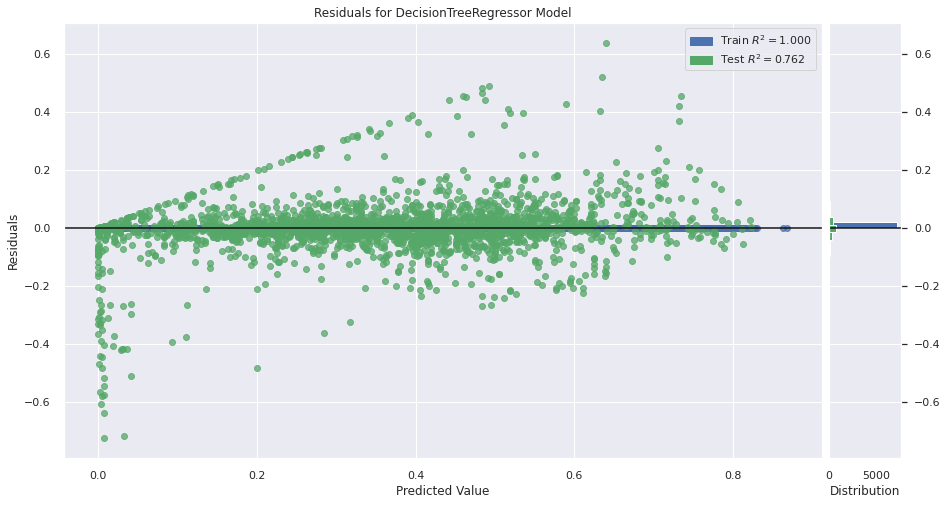

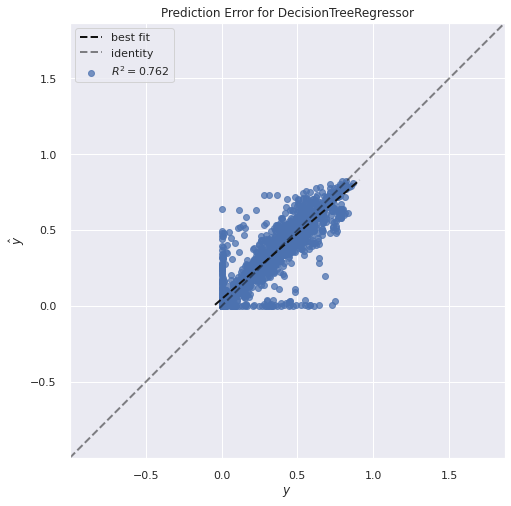

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


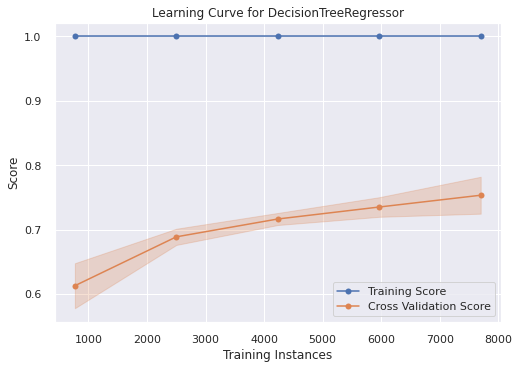

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


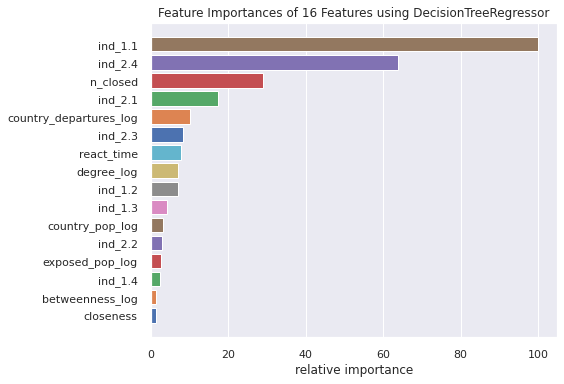

/disks/hdd2T/Drive/TFM/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of 16 Features using DecisionTreeRegressor'}, xlabel='relative importance'>,
                   model=None)

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
viz = residuals_plot(pipe, X_train, y_train, X_test, y_test, ax=ax)

fig, ax = plt.subplots(1,1, figsize=(15,8))
viz = prediction_error(pipe, X_train, y_train, X_test, y_test, ax=ax)

learning_curve(pipe, X, y, scoring='r2', n_jobs=-1)

feature_importances(estimator, X, y)